## Redes Neuronales para regresión

Basado en notebook de Noelia Echeverría.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Por ahora vamos a trabajar con un Toy Dataset. Para cargarlo y poder trabajar con él debemos poner `datasets.load_boston()` <br>

Al hacerlo, se carga en una variable un objeto de tipo `bunch`. Hay 4 keys relevantes en este objeto.
> * `data`
* `target`
* `feature_names`
* `DESCR`

![separador](https://i.imgur.com/4gX5WFr.png)

### **Feature Names**

**¿Qué significan los feature names?** <br>

* **CRIM** = Tasa de crimen per-capita del barrio
* **ZN** = proporción de terrenos residenciales divididos en zonas para lotes de más de 25,000 pies cuadrados
* **INDUS** = proporción de acres de negocios no minoristas por ciudad
* **CHAS** = variable ficticia de Charles River (= 1 si el tramo limita el río, 0 de lo contrario)
* **NOX** =  concentración de óxidos nítricos (partes por 10 millones)
* **RM** = número promedio de habitaciones por vivienda
* **AGE** = proporción de unidades ocupadas por sus propietarios construidas antes de 1940
* **DIS** = Distancias ponderadas a cinco centros de empleo de Boston
* **RAD** = índice de accesibilidad a las autopistas radiales
* **TAX** = Tasa de impuesto a la propiedad de valor total por $ 10,000
* **PTRATIO** =  colegios por localidad
* **B** =  1000 (Bk - 0,63)^ 2, donde Bk es la proporción de negros por ciudad
* **LSTAT** = porcentaje del status mas bajo de la poblacion

Disclaimer: Este dataset tiene algunas columnas controversiales, de índole racista.



### Transformamos a Pandas DataFrame

In [5]:
boston_df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")

In [8]:
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# Preprocesamiento

(suele ser necesario, pero no lo vamos a ejecutar en clase)



---
#### Buscamos missing values

---

In [9]:
# buscamos valores nulos 
print(boston_df.isnull().sum()) # --> NO hay valores nulos

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


---
Mostramos la estadística del dataset

---

In [10]:
print(boston_df.describe())

             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio           b  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

---

#### Exploramos los datos

El precio de las casas tiene una distribución "similar" a una distribución normal, con algunos outliers.

---

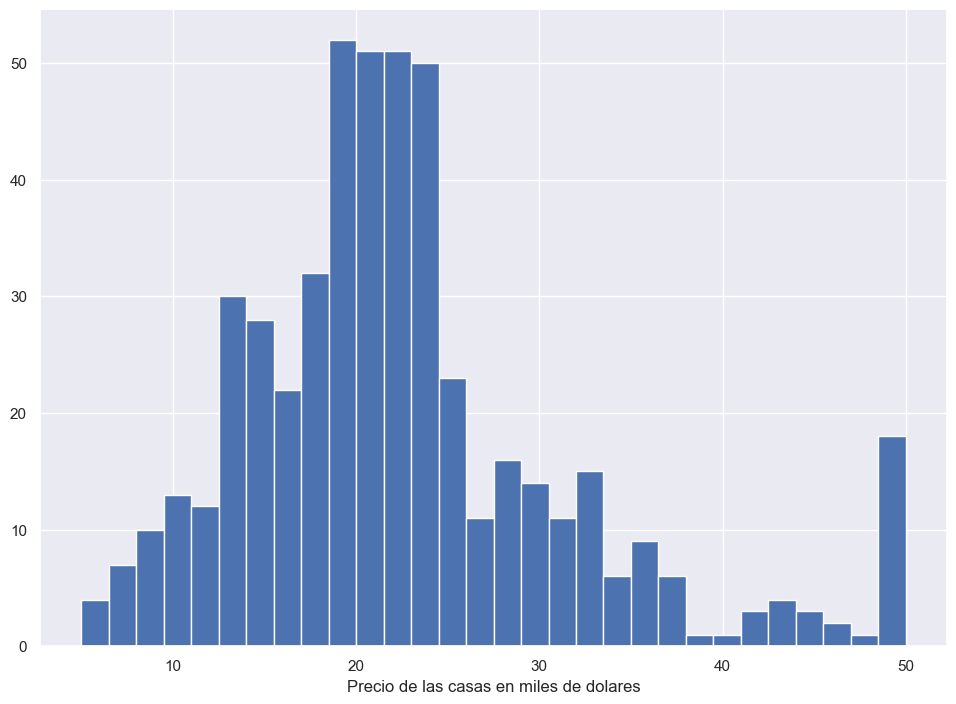

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(boston_df['medv'], bins=30)
plt.xlabel("Precio de las casas en miles de dolares")
plt.show()

---
#### Mapa de Calor (HeatMap) - Correlaciones entre las columnas. 

---
Podemos observar altas correlaciones entre el precio (PRICE) y :
* RM (correlacion 0.7)  --> cantidad de habitaciones
* LSTAT (correlacion -0.74) --> Porcentaje del nivel mas bajo de la poblacion
* PTRATIO (correlacion -0.51) --> Cantidad de colegios en la ciudad
* TAX (correlacion -0.47) --> impuestos

---

<Axes: >

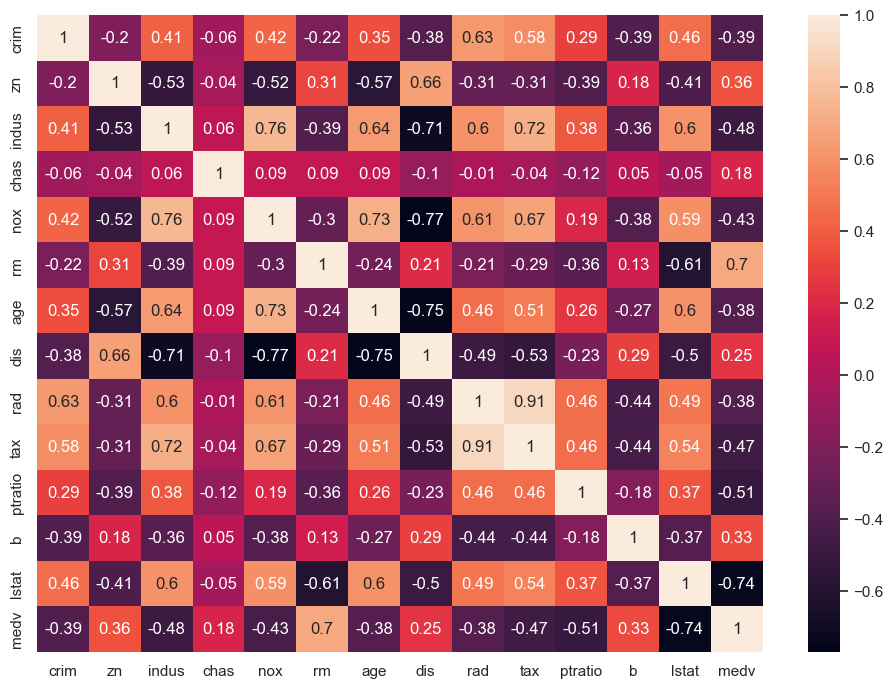

In [13]:
# Vamos a ver las correlaciones entre el precio y los features
correlation_matrix = boston_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

---
#### Graficamos los features candidatos a entrenar nuestra red

---

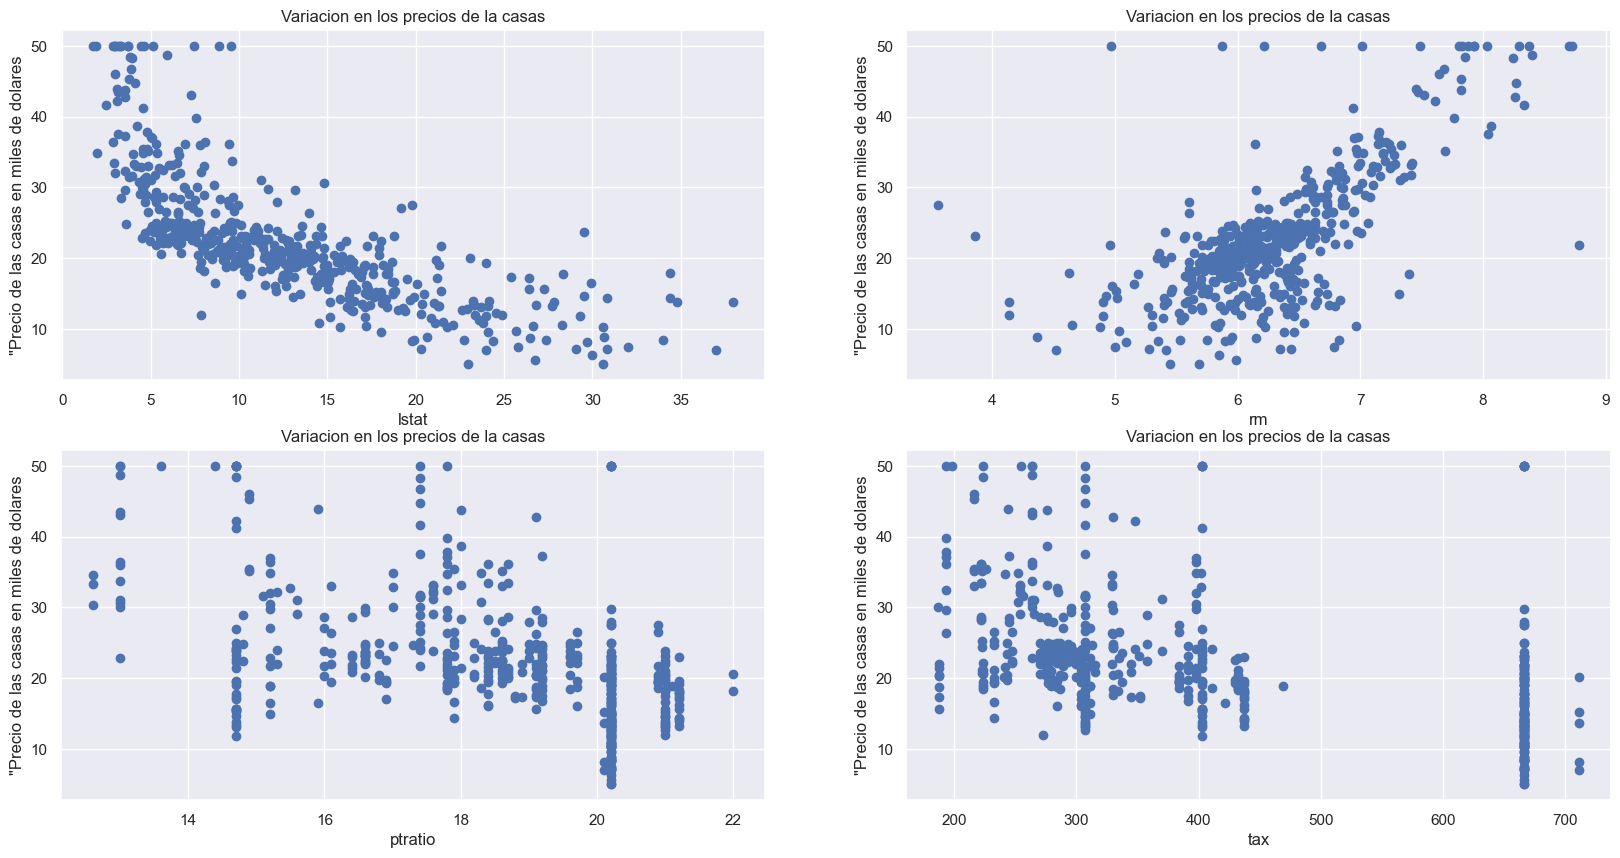

In [15]:
plt.figure(figsize=(20, 10))

features = ['lstat', 'rm', 'ptratio', 'tax']
target = boston_df['medv']

for i, col in enumerate(features):
    plt.subplot(2, 2 , i+1)
    x = boston_df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title("Variacion en los precios de la casas")
    plt.xlabel(col)
    plt.ylabel('"Precio de las casas en miles de dolares')

---
Al graficar nos damos cuenta que:<br>
* El precio de la casa se incrementa con el número de habitaciones (RM)
* El precio se decrementa cuanto más empobrecida está la zona (LSTAT)

* PTRATIO y TAX no nos brindan demasiada información del precio de la casa

---

Para entrenar nuestra red vamos a utilizar RM y LSTAT

---


# Funciones para entrenamiento

Vamos a definir algunas funciones para trabajar

Armado de modelo para regresion:

```python
model = Sequential()
model.add(Dense(128, input_dim=n_train_dim, activation='relu'))    
model.add(Dense(1, activation='linear'))

    
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
```


Entrenamiento del modelo:

```python
result = model.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=1)

```

Para obtener los resultados de loss:

```python
loss = result.history['loss']
val_loss = result.history['val_loss']
```

Para ver los resultados de la métrica:

```python
mae = result.history['mae']    
val_mae = result.history['val_mae']

```

Para hacer predicciones sobre conjunto de test:

```python
predictions = model.predict(X_test)
```

In [16]:
def myModel(X, y, random_state=1, scale=True, test_size=0.1):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)
    scaler = StandardScaler().fit(X_train)

    if scale:
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test) # cuidado, al aplicar el standard scaler, los datos dejan de ser dataframes    

    n_train_samples, n_train_dim = X_train.shape


    # Para regresion utilizamos una unica capa oculta
    model = Sequential()
    model.add(Dense(128, input_dim=n_train_dim, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    model.summary()

    return model, X_train, X_test, y_train, y_test

In [17]:

def trainMyModel(model, X_train, y_train):

    result = model.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=1)
    
    print("history.keys = ",result.history.keys())
    
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(7,7))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()


    mae = result.history['mae']    
    val_mae = result.history['val_mae']

    
    plt.figure(figsize=(7,7))
    plt.plot(epochs, mae, 'y', label='Training MAE')
    plt.plot(epochs, val_mae, 'r', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

In [18]:
def makePredictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    y_test = np.array(y_test)
   
    predicted_value = np.array(predictions)
    predicted_value = predicted_value.reshape(max(predicted_value.shape), )

    return predicted_value

In [19]:

def plotPredictionsOnTwoAxes(predicted_value, X_test, y_test):

    data = np.array(X_test)  # ploteo con los datos sin estandarizar

    if (X_test.shape[1]==2) :
        data1 = data[:, 0]
        data2 = data[:, 1]
    else: 
        data1 = data[:, 5]
        data2 = data[:, 12]
    true_value = np.array(y_test)
    plt.subplot(2, 1 , 1)
    plt.scatter(data1, true_value, marker='o', c='r')   
    plt.scatter(data1, predicted_value, marker='o', c='b')
    plt.ylabel('"Precio de las casas en miles de dolares')
    plt.subplot(2, 1 , 2)
    plt.scatter(data2, true_value, marker='o', c='r')
    plt.scatter(data2, predicted_value, marker='o', c='b')
    plt.ylabel('"Precio de las casas en miles de dolares')
    plt.suptitle("Estimación de precios de casas - azul true value - red estimated value [DATOS DE TESTEO]")
    return data1, data2

In [20]:
def plotPredictionsSeparated(predicted_value, X_test, y_test):

    data = np.array(X_test)  # ploteo con los datos sin estandarizar

    if (X_test.shape[1]==2) :
        data1 = data[:, 0]
        data2 = data[:, 1]
    else: 
        data1 = data[:, 5]
        data2 = data[:, 12]
    true_value = np.array(y_test)
    plt.subplot(2, 2 , 1)
    plt.scatter(data1, true_value, marker='o', c='r')   
    plt.ylabel('Precio en miles de dolares')
    plt.title("True")
    plt.subplot(2, 2 , 2)
    plt.scatter(data1, predicted_value, marker='o', c='b')
    plt.ylabel('Precio en miles de dolares')
    plt.title("Predicted")
    plt.subplot(2, 2 , 3)
    plt.scatter(data2, true_value, marker='o', c='r')
    plt.ylabel('Precio en miles de dolares')
    plt.title("True")
    plt.subplot(2, 2 , 4)
    plt.scatter(data2, predicted_value, marker='o', c='b')
    plt.ylabel('Precio en miles de dolares')
    plt.title("Predicted")
    plt.suptitle("Estimación de precios de casas - azul true value - red estimated value [DATOS DE TESTEO]")
    return data1, data2

In [21]:

def plotTwoModels(data11, data12, true_value, predicted_value1, data21, data22, predicted_value2):
    plt.figure(figsize=(15,12))
    plt.subplot(2, 2 , 1)
    plt.scatter(data11, true_value, marker='o', c='r')
    plt.scatter(data11, predicted_value1, marker='o', c='b')
    plt.ylabel('Precio de las casas en miles de dolares')
    plt.title("True value - 2 parametros de entrenamiento - PRICE VS RM")
    plt.subplot(2, 2 , 2)
    plt.scatter(data12, true_value, marker='o', c='r')
    plt.scatter(data12, predicted_value1, marker='o', c='b')
    plt.ylabel('Precio de las casas en miles de dolares')
    plt.title("Predicted value - 2 parametros de entrenamiento - PRICE VS LSTAT")
    plt.suptitle("Estimación de precios de casas - azul true value - red estimated value [DATOS DE TESTEO]")
    plt.subplot(2, 2 , 3)
    plt.scatter(data21, true_value, marker='o', c='m')
    plt.scatter(data21, predicted_value2, marker='o', c='c')
    plt.ylabel('Precio de las casas en miles de dolares')
    plt.title("True value - 13 parametros de entrenamiento - PRICE VS RM")
    plt.subplot(2, 2 , 4)
    plt.scatter(data22, true_value, marker='o', c='m')
    plt.scatter(data22, predicted_value2, marker='o', c='c')
    plt.ylabel('"Precio de las casas en miles de dolares')
    plt.title("Predicted value - 13 parametros de entrenamiento - PRICE VS LSTAT")
    plt.suptitle("Estimación de precios de casas - Red entrenada con 2 parametros - Red Entrenada con 13 parametros")


### **Modelo 1**

#### 2 features de entrenamiento

* `RM`
* `LSTAT`


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 1s 20ms/step - loss: 635.1202 - mae: 23.4681 - val_loss: 555.4891 - val_mae: 21.3589
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 539.0982 - mae: 21.0812 - val_loss: 466.4401 - val_mae: 18.8796
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 455.4853 - mae: 18.7347 - val_loss: 389.1205 - val_mae: 16.6254
Epoch 4/10

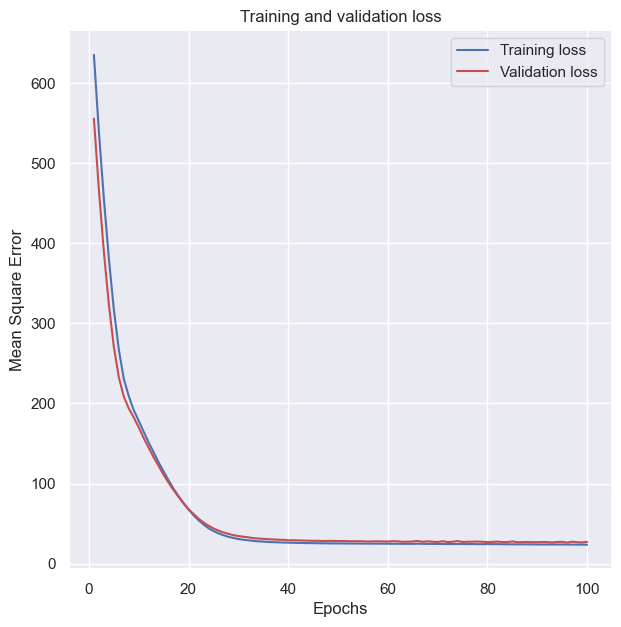

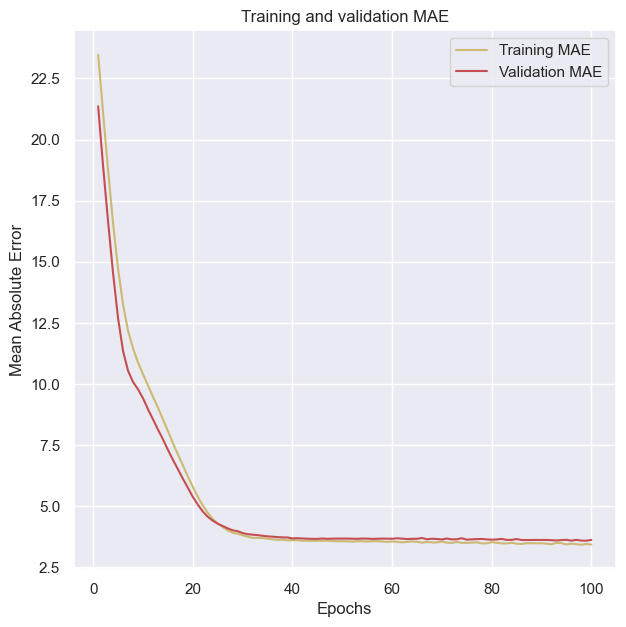

2/2 [==============================] - 0s 0s/step


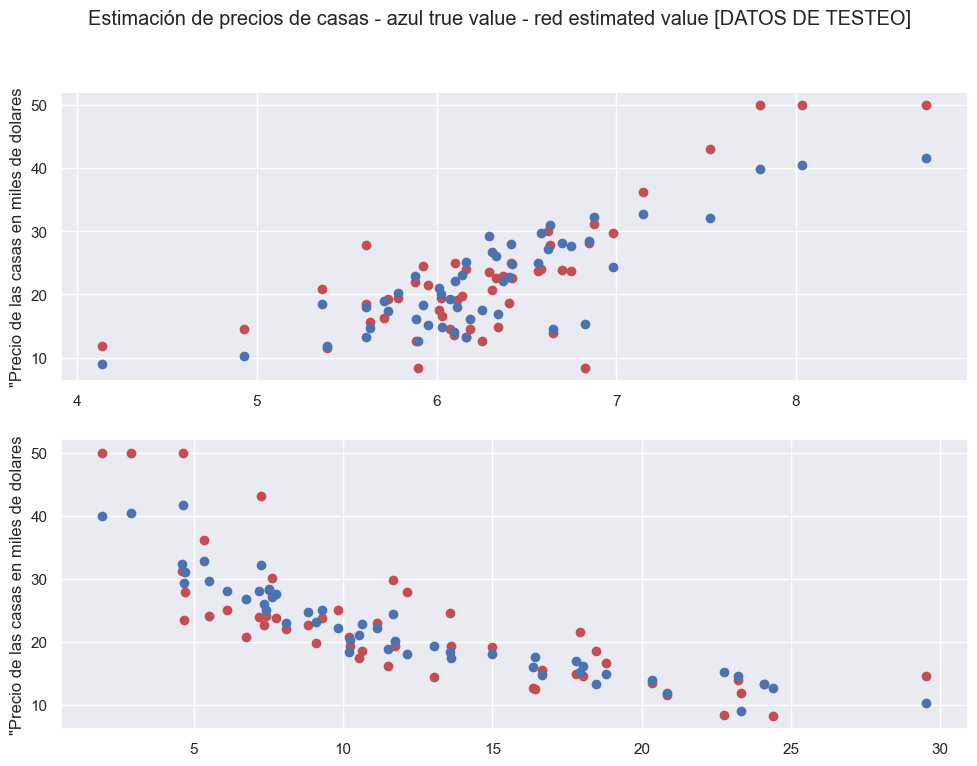

In [22]:
X = boston_df[["rm", "lstat"]]
y = boston_df["medv"]  # no es lo mismo que tenga 1 par de corchetes o dos pares de corchetes
model, X_train, X_test, y_train, y_test = myModel(X, y, random_state=1, scale=False)
trainMyModel(model, X_train, y_train)
predicted_value = makePredictions(model, X_test, y_test)
data11, data12 = plotPredictionsOnTwoAxes(predicted_value, X_test, y_test)

(array([6.849, 6.696, 6.03 , 5.878, 5.362, 6.372, 6.63 , 6.072, 5.951,
        6.417, 6.75 , 6.874, 5.731, 5.787, 6.023, 5.608, 6.649, 8.725,
        6.162, 4.926, 5.705, 5.628, 6.567, 6.415, 6.29 , 5.896, 6.096,
        6.014, 7.52 , 5.39 , 6.579, 5.605, 8.034, 6.251, 6.144, 5.926,
        6.341, 7.147, 4.138, 6.114, 6.333, 6.31 , 6.618, 6.162, 6.185,
        6.824, 7.802, 5.887, 6.101, 6.405, 6.98 ]),
 array([ 7.53,  7.18, 18.8 ,  8.1 , 10.19, 11.12,  4.7 , 13.04, 17.92,
         8.81,  7.74,  4.61, 13.61, 10.24, 11.72, 12.13, 23.24,  4.63,
         7.43, 29.53, 11.5 , 16.65,  9.28,  6.12,  4.67, 24.39, 20.34,
        10.53,  7.26, 20.85,  5.49, 18.46,  2.88, 16.44,  9.09, 13.59,
        17.79,  5.33, 23.34, 14.98,  7.34,  6.75,  7.6 , 24.1 , 18.03,
        22.74,  1.92, 16.35,  9.81, 10.63, 11.66]))

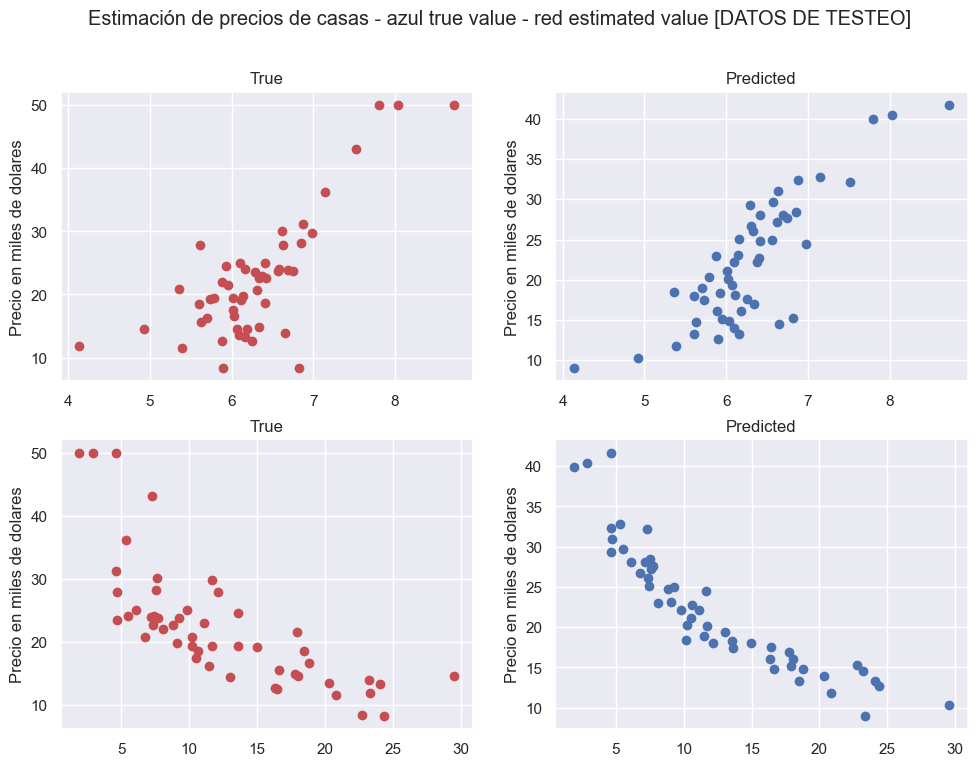

In [23]:
plotPredictionsSeparated(predicted_value, X_test, y_test)


### **Modelo 2**

#### 13 features de entrenamiento


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1792      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1921 (7.50 KB)
Trainable params: 1921 (7.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 1s 20ms/step - loss: 593.1456 - mae: 22.5530 - val_loss: 556.0549 - val_mae: 21.5503
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 562.9971 - mae: 21.9266 - val_loss: 528.1317 - val_mae: 20.9538
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 533.1081 - mae: 21.2922 - val_loss: 499.5891 - val_mae: 20.3362
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 502.1284 - mae: 20.6055 - val_loss: 468.7312 - val_mae: 19.6395
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 468.8476 - mae: 19.8427 - val_loss: 434.9681 - val_mae: 18.8617
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 432.3675 - mae: 18.9645 - val_loss: 398.3963 - val_mae: 17.9610
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 393.4746 - mae: 17.9726 - val_loss: 360.0449 - val_mae: 17.0079
Epoch 8/100
12/12 [=====================

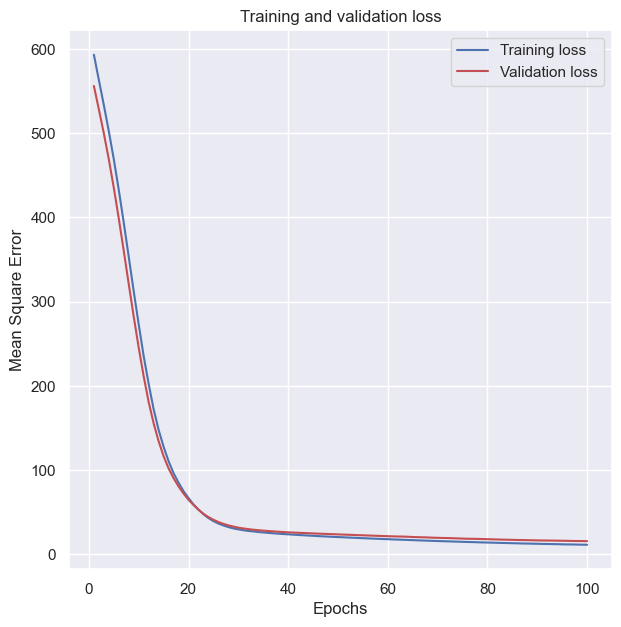

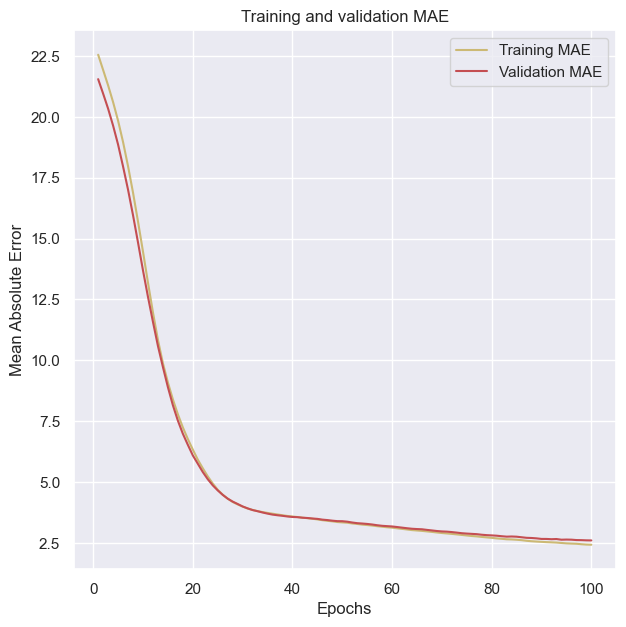

2/2 [==============================] - 0s 3ms/step


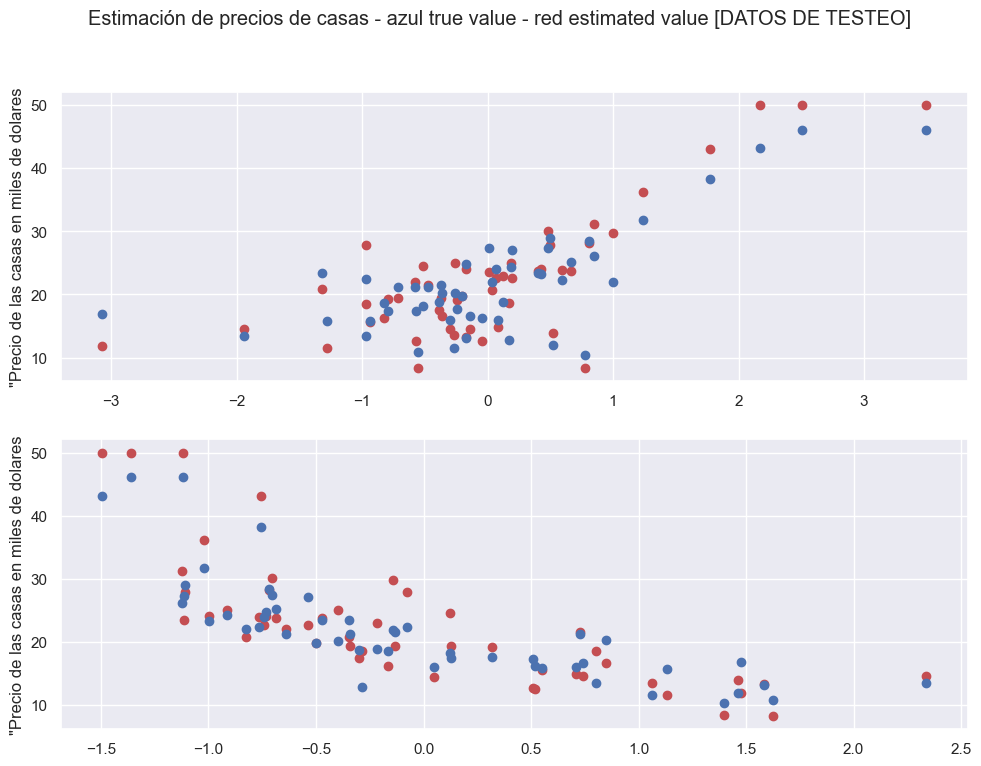

In [24]:
# Prueba 2 --> 13 datos como features
X1 = boston_df[["crim", "zn" , "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "b", "lstat"]]
y1 = boston_df["medv"]  # no es lo mismo que tenga 1 par de corchetes o dos pares de corchetes
model1, X1_train, X1_test, y1_train, y1_test = myModel(X1, y1, random_state=1, scale=True)
trainMyModel(model1, X1_train, y1_train)
predicted_value1 = makePredictions(model1, X1_test, y1_test)
data21, data22 = plotPredictionsOnTwoAxes(predicted_value1, X1_test, y1_test)

(array([ 0.80948285,  0.59035789, -0.36348021, -0.58117299, -1.32018269,
         0.12632854,  0.49583339, -0.30332826, -0.47662317,  0.19077706,
         0.66769611,  0.84528759, -0.79170482, -0.71150222, -0.37350554,
        -0.96786411,  0.52304499,  3.49627005, -0.17443122, -1.94461723,
        -0.82894174, -0.93922032,  0.40560546,  0.18791268,  0.00888902,
        -0.55539358, -0.26895571, -0.38639524,  1.7704819 , -1.28008138,
         0.42279173, -0.97216068,  2.50662722, -0.04696637, -0.20021063,
        -0.5124279 ,  0.08193067,  1.23627528, -3.07318243, -0.24317631,
         0.07047316,  0.0375328 ,  0.47864712, -0.17443122, -0.14149086,
         0.77367812,  2.17435929, -0.56828328, -0.26179477,  0.17359079,
         0.99709966]),
 array([-0.71650549, -0.76509904,  0.84820699, -0.63736741, -0.34719447,
        -0.21807445, -1.10941909,  0.04849591,  0.72602891, -0.53879192,
        -0.68734936, -1.12191458,  0.12763399, -0.34025253, -0.13477121,
        -0.07784733,  1.4646

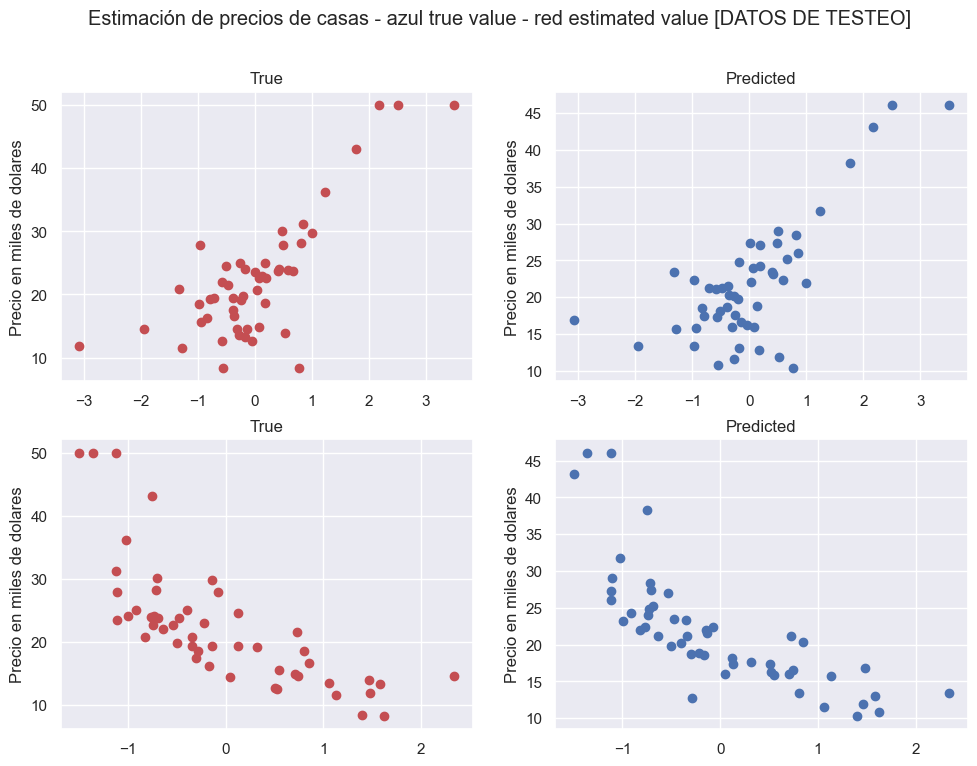

In [25]:
plotPredictionsSeparated(predicted_value1, X1_test, y1_test)


### Ploteamos los resultados de los dos modelos


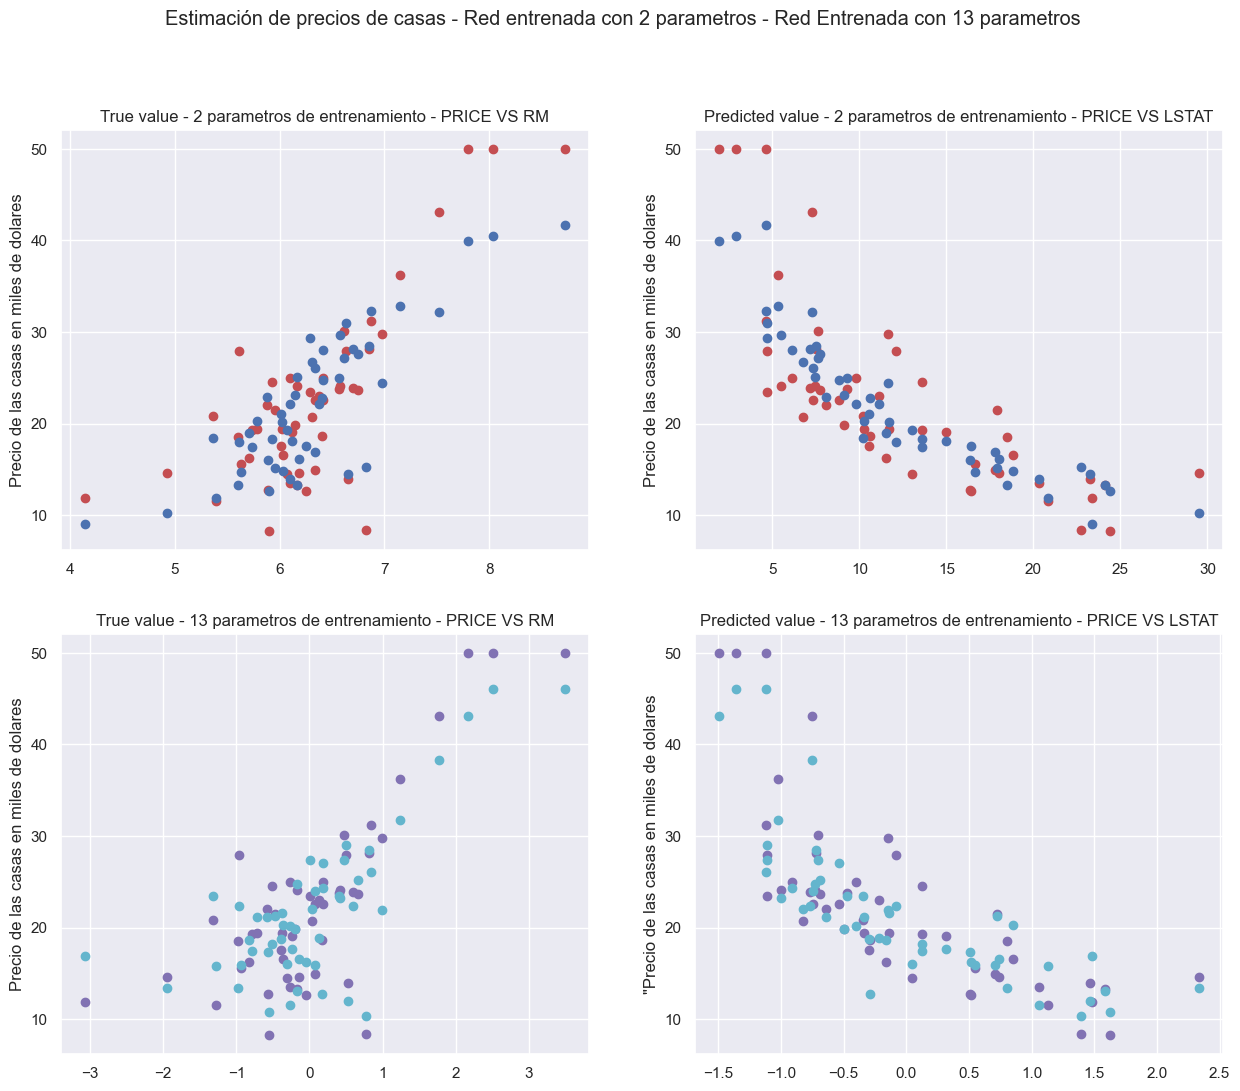

In [26]:
plotTwoModels(data11, data12, y_test, predicted_value, data21, data22, predicted_value1)